In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-057088e0c8b3>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [7]:
# Create df of only Manhattan data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Qns', 'Accidents_Bkln', 'Accidents_SI',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_Man': 'y'},inplace=True)


In [8]:
df_prophet.head()

,y,ds
Date,,
2012-07-01,122.0,2012-07-01
2012-07-02,122.0,2012-07-02
2012-07-03,155.0,2012-07-03
2012-07-04,71.0,2012-07-04
2012-07-05,114.0,2012-07-05


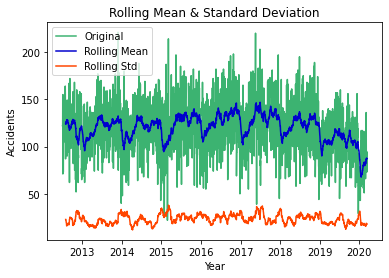

Test Statistic                   -4.079844
p-value                           0.001046
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [9]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Facebook Prophet Modeling

## Train-Test Split

In [10]:
# Train-test split
# 2019-06-06 will be the split point for our train and test sets, which is a 90%/10% split

X = df_prophet.index
y = df_prophet['y']

train = df_prophet.loc[:'2019-06-06']
test = df_prophet.loc['2019-06-07':]

X_train, X_test = train.index , test.index
y_train, y_test = train['y'] , test['y']

## Fit Model and Generate Predictions

In [11]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# Make predictions 1120 days into the future--ie until 6/30/22
# This way we will have a full year of model-predicted data after starting on 7/1/21
# Create future dates
future_dates = model.make_future_dataframe(periods=1120, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3647,2022-06-26,82.121174,25.528029,99.816832,71.879972,93.057221,-19.272385,-19.272385,-19.272385,-26.023237,-26.023237,-26.023237,6.750852,6.750852,6.750852,0.0,0.0,0.0,62.848789
3648,2022-06-27,82.094111,43.563576,118.466084,71.840976,93.034128,-2.239661,-2.239661,-2.239661,-7.965165,-7.965165,-7.965165,5.725504,5.725504,5.725504,0.0,0.0,0.0,79.854450
3649,2022-06-28,82.067048,51.983951,127.889860,71.801980,93.011034,9.885891,9.885891,9.885891,5.197276,5.197276,5.197276,4.688615,4.688615,4.688615,0.0,0.0,0.0,91.952939
3650,2022-06-29,82.039986,52.240672,128.394141,71.762984,92.987940,9.526116,9.526116,9.526116,5.864701,5.864701,5.864701,3.661415,3.661415,3.661415,0.0,0.0,0.0,91.566101
3651,2022-06-30,82.012923,59.333128,133.746306,71.723988,92.964847,13.597122,13.597122,13.597122,10.932031,10.932031,10.932031,2.665091,2.665091,2.665091,0.0,0.0,0.0,95.610045


## Visualize Model

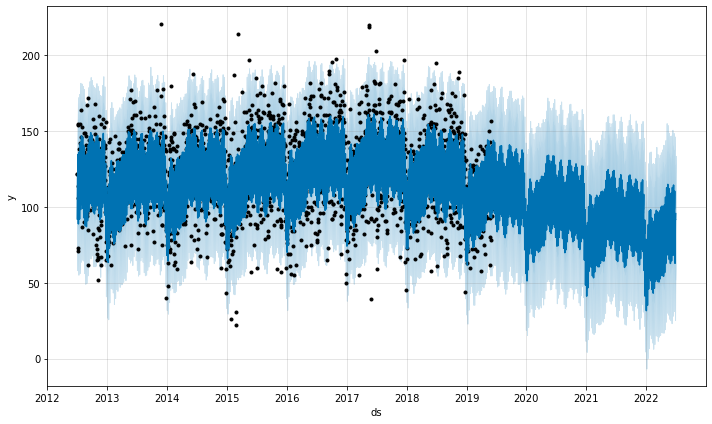

In [13]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

## Assess Model

In [14]:
# Assess model using RMSE to compare to our working SARIMAX model
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# Define test predictions
test_preds = forecast.set_index('ds').loc['2019-06-07':'2020-03-13']

# Define fb prophet RMSE
fb_RMSE = RMSE(test_preds['yhat'])

# Compare to SARIMAX RMSE to determine the better model
print('FB Prophet: RMSE: ', fb_RMSE, ', Adjusted RMSE: ', fb_RMSE/(forecast['yhat'].max()-forecast['yhat'].min()))
print('SARIMAX: RMSE: ', 11.093035021610836, ', Adjusted RMSE: ', 0.10579188712707882)

FB Prophet: RMSE:  19.045171667993195 , Adjusted RMSE:  0.1467950537201338
SARIMAX: RMSE:  11.093035021610836 , Adjusted RMSE:  0.10579188712707882


Based on the above adjusted RMSEs, we see that our SARIMAX model performs 28% better than our ARIMA model. We will therefore consider this our best model and will not move forward with our FB Prophet model.